# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [1]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [4]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label) - 1] = name

activity_labels

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

Let's normalize data

In [5]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [6]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [7]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

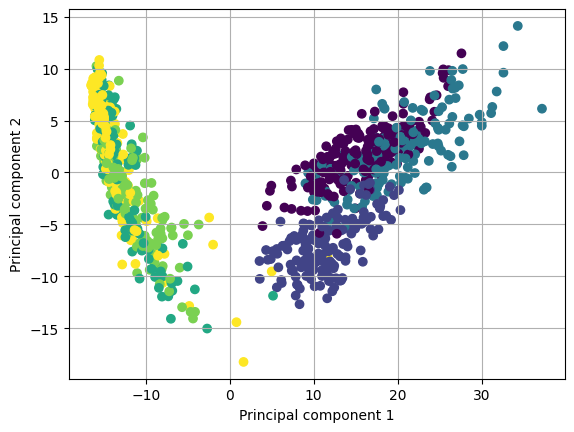

In [10]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

Text(0, 0.5, 'Principal component 5')

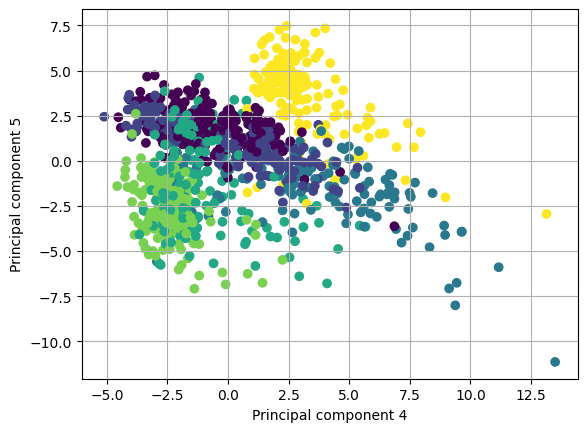

In [11]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [12]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import ucimlrepo as uci

In [14]:
#dataset = uci.fetch_ucirepo(id=186)

#print(dataset.metadata.name, '\n')
#print(dataset.metadata.abstract, '\n')
#print(dataset.metadata.additional_info.summary, '\n')

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [15]:

y_test -= 1
y_train -= 1
print(np.unique(y_train))

[0. 1. 2. 3. 4. 5.]


In [17]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

train_xgb = xgb.DMatrix(X_train_pca, label=y_train)
test_xgb = xgb.DMatrix(X_test_pca, label=y_test)

params = {
    'booster' : 'gbtree', # тип бустера здесь градиентный
    'objective': 'multi:softmax',  # функция потерь, здесь используется функция для многоклассовой классификации
    'eta': 0.5,  # скорость обучения
    'max_depth': 3,  # максимальная глубина дерева
    'min_child_weight': 1, # количество объектов, ниже которого мы не будем делить дерево (помогает модели не переобучаться)
    'subsample': 1, # доля выборки для обучения
    'colsample_bytree': 1, # доля признаков для обучения
    'gamma': 0.0, # минимальное уменьешние потерь для разделения узла
    'eval_metric': 'mlogloss', # метрика для оценки модели
    'num_class': 6}  # число классов
num_boost_round = 100  # boosting iteration num

bst = xgb.train(params, dtrain=train_xgb, num_boost_round=num_boost_round)

preds = bst.predict(test_xgb)

best_preds = np.asarray(preds)

print(f'accuracy score: {accuracy_score(y_test, best_preds):.4f}')
# Example: https://rpubs.com/burakh/har_xgb

accuracy score: 0.9264


## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [18]:
import optuna
from sklearn.model_selection import train_test_split

#делим данные на тренировку и валидацию
X_train_optuna, X_val, y_train_optuna, y_val = train_test_split(X_train_pca, y_train, test_size=0.1, random_state=42)

#преобразуем в удобный для xgboost формат
train_xgb = xgb.DMatrix(X_train_optuna, label=y_train_optuna)
val_xgb = xgb.DMatrix(X_val, label=y_val)

def objective(trial):
    params = {
        'booster' : 'gbtree', # тип бустера здесь градиентный
        'objective': 'multi:softmax',  # функция потерь, здесь используется функция для многоклассовой классификации
        'eta': trial.suggest_float('eta', 0.3, 0.9),  # скорость обучения
        'max_depth': trial.suggest_int('max_depth', 1, 5),  # максимальная глубина дерева
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5), # количество объектов, ниже которого мы не будем делить дерево (помогает модели не переобучаться)
        'subsample': 1, # доля выборки для обучения
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5), # доля признаков для обучения
        'gamma': trial.suggest_float('gamma', 0.0, 1), # минимальное уменьешние потерь для разделения узла
        'eval_metric': 'mlogloss', # метрика для оценки модели
        'num_class': 6}  # число классов
    num_round = 100 # boosting iteration num

    model = xgb.train(params=params, dtrain=train_xgb, num_boost_round=num_round)

    y_predictions = model.predict(val_xgb)

    trial.set_user_attr('model', model) # созраняем в trail нашу модель

    return accuracy_score(y_val, y_predictions)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)


c:\Users\Копатыч2\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-17 18:34:06,256] A new study created in memory with name: no-name-2d2488f9-970b-4c99-898b-70b3af960545
[I 2024-11-17 18:34:07,435] Trial 0 finished with value: 0.9605978260869565 and parameters: {'eta': 0.8749032932367531, 'max_depth': 2, 'min_child_weight': 1, 'colsample_bytree': 0.166467099521158, 'gamma': 0.5218620390955024}. Best is trial 0 with value: 0.9605978260869565.
[I 2024-11-17 18:34:09,146] Trial 1 finished with value: 0.9565217391304348 and parameters: {'eta': 0.508998391926732, 'max_depth': 4, 'min_child_weight': 3, 'colsample_bytree': 0.16285463668055333, 'gamma': 0.8457255799146575}. Best is trial 0 with value: 0.9605978260869565.
[I 2024-11-17 18:34:10,434] Trial 2 finished with val

In [ ]:
print(study.best_params)
study.best_value

{'eta': 0.7792993530742874, 'max_depth': 2, 'min_child_weight': 4, 'colsample_bytree': 0.16293096211618222, 'gamma': 0.7475097152476917}


0.9755434782608695

In [ ]:
final_model = study.best_trial.user_attrs['model']

y_pred = final_model.predict(test_xgb)
print(f'accuracy score: {accuracy_score(y_test, y_pred):.4f}')

accuracy score: 0.9152


### Conclusion

Please, write down your thoughts on the experiment results:

Accuracy упала, да и на тренировку модели ушло ощутимо больше времени, возможно она ещё недообучилась и n_trials следует выставить больше, но на это уйдёт ещё больше времени, а без этого accyracy и так 0,92 на 6-и классовой задаче. Очень сомнительно использовать здесь такой метод.

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

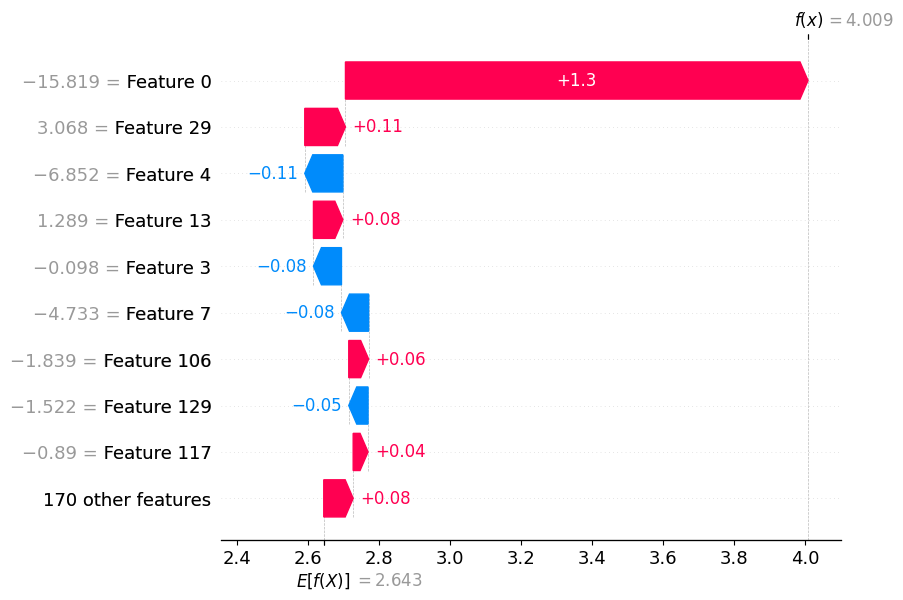

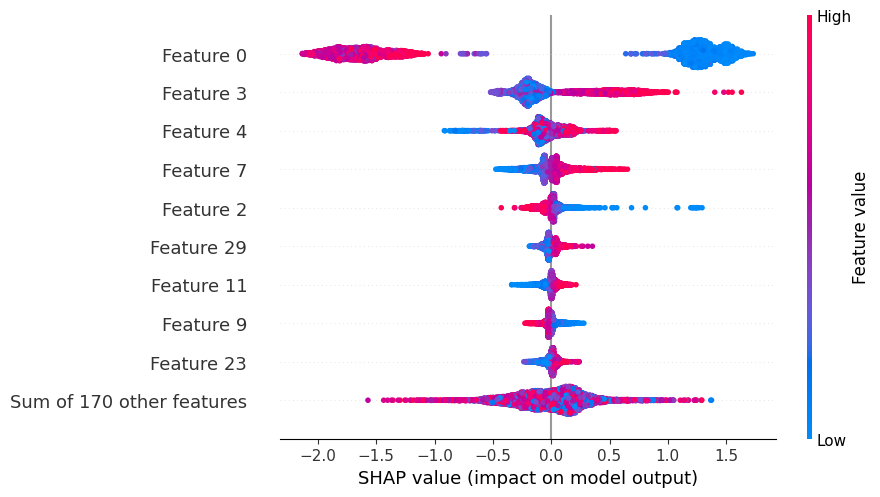

In [27]:
import shap  # noqa: F401

# train an XGBoost model
model = xgb.XGBRegressor().fit(X_train_pca, y_train)

# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_train_pca)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# summarize the effects of all the features
shap.plots.beeswarm(shap_values)


### Conclusion

Your thoughts about the plots and model behaviour:

Я построил два графика:

1)первый показывает как каждая  фича влияет на класс, из него видно, что больше всего влияет на резульатт предсказания 0 фича(как она отклоняет класс от среднего)

2)рассмотрим 0 фичу на втором графике: тут видно, чем меньше значения фичи, тем больше будет класс, в котором находится предсаказываемый результат. И так сделано для самых показательных фичей.

3)важно отметить, что это похоже на правду, так как например для нулевой фичи очень заметно на первом графике такое разделение.